# Data Science Workflow - Titanic

In this project, we will compete the most popular competition in Kaggle - [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic).

In this competition, we have a data set of different information about passengers onboard the Titanic, and we want to see if we can use that information to predict whether those people survived or not.

The type of machine learning we will use is classification, because when we make predictions we are classifying each passenger as a survivor or not.

## Data Introduction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [2]:
# first 3 rows
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Data Exploration and Feature Engineering

Anyone who has watched the movie Titanic would remember that women and children were given preference to lifeboats, and you would also noticed that vast class disparity of the passengers.

So, first we will start by exploring `Sex`, `Age` and `Pclass` columns.

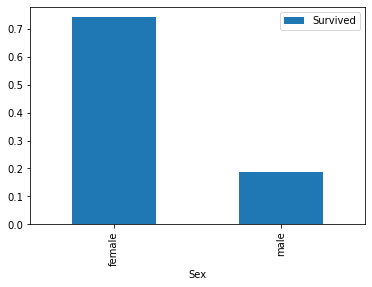

In [4]:
# Sex columns
train.pivot_table(index='Sex', values='Survived').plot.bar()
plt.show()

In [5]:
# Age columns
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

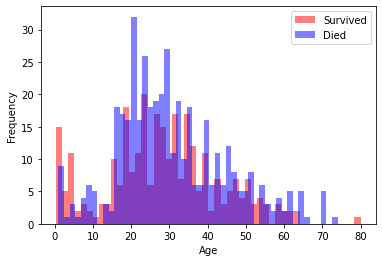

In [6]:
survived = train[train['Survived']==1]
died = train[train['Survived']==0]
survived['Age'].plot.hist(alpha=0.5, color='red',bins=50)
died['Age'].plot.hist(alpha=0.5, color='blue', bins=50)
plt.xlabel('Age')
plt.legend(['Survived', 'Died'])

plt.show()

The relationship here is not simple, but we can see that in some age ranges more passengers survived.
In order for this to be useful to our machine learning model, we can separate this continuous feature into a categorical feature by dividing it into ranges.

In [7]:
def process_age(df, cut_points, label_names):
    
    # handle missing value
    df['Age'] = df['Age'].fillna(-0.5)
    
    # divide it into ranges
    df['Age_categories'] = pd.cut(df['Age'], cut_points, labels=label_names)
    
    return df

cut_points = [-1, 0, 5, 12, 18, 35, 60, 100]
label_names = ['Missing', 'Infant', 'Child', 'Teenager', 'Young Adult',
               'Adult', 'Senior']

# process both data set

for df in (train, holdout):
    df = process_age(df, cut_points, label_names)


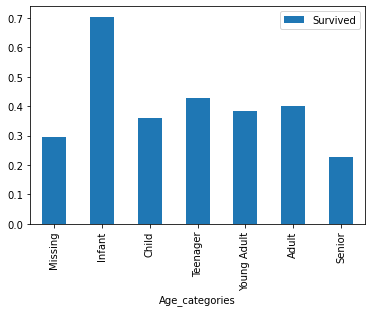

In [8]:
train.pivot_table(index='Age_categories', values='Survived').plot.bar()
plt.show()

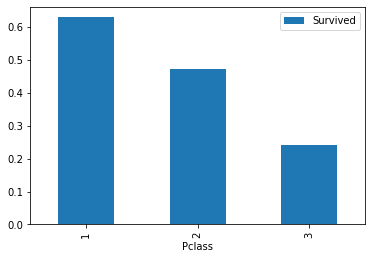

In [9]:
# Pclass columns
train.pivot_table(index='Pclass', values='Survived').plot.bar()
plt.show()

Next, let's explore the `Embarked`, `SibSp`, `Parch` and `Fare` columns in both our train and holdout dataframes.

In [10]:
train[['SibSp','Parch','Fare','Embarked']].describe(include='all')

,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,889
unique,NaN,NaN,NaN,3
top,NaN,NaN,NaN,S
freq,NaN,NaN,NaN,644
mean,0.523008,0.381594,32.204208,NaN
std,1.102743,0.806057,49.693429,NaN
min,0.000000,0.000000,0.000000,NaN
25%,0.000000,0.000000,7.910400,NaN
50%,0.000000,0.000000,14.454200,NaN
75%,1.000000,0.000000,31.000000,NaN


In [11]:
holdout[['SibSp','Parch','Fare','Embarked']].describe(include='all')

,SibSp,Parch,Fare,Embarked
count,418.000000,418.000000,417.000000,418
unique,NaN,NaN,NaN,3
top,NaN,NaN,NaN,S
freq,NaN,NaN,NaN,270
mean,0.447368,0.392344,35.627188,NaN
std,0.896760,0.981429,55.907576,NaN
min,0.000000,0.000000,0.000000,NaN
25%,0.000000,0.000000,7.895800,NaN
50%,0.000000,0.000000,14.454200,NaN
75%,1.000000,0.000000,31.500000,NaN


In [12]:
# handle missing value

# fill na with mode
train['Embarked'].fillna('S', inplace=True)
holdout['Embarked'].fillna('S', inplace=True)

# fill na with mean
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())

Looking at our numeric columns(`SibSp`, `Parch`, `Fare`), we can see a big difference between the range of each.
In order to make sure these values are equally weighted within our model, we'll need to rescale the data

In [13]:
# rescale
from sklearn.preprocessing import minmax_scale


numeric_cols = ['SibSp', 'Parch', 'Fare']
for col in numeric_cols:
    train[col+'_scaled'] = minmax_scale(train[col])
    holdout[col+'_scaled'] = minmax_scale(holdout[col])

Just like `Age` column,we will apply similar method to the `Fare` columns to divide the continous values into ranges.

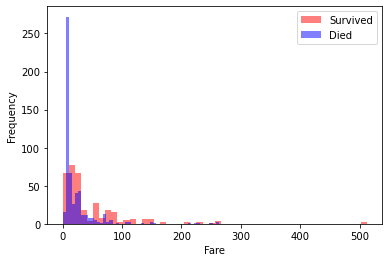

In [14]:
# Fare columns

survived = train[train['Survived']==1]
died = train[train['Survived']==0]
survived['Fare'].plot.hist(alpha=0.5, color='red',bins=50)
died['Fare'].plot.hist(alpha=0.5, color='blue', bins=50)
plt.xlabel('Fare')
plt.legend(['Survived', 'Died'])

plt.show()

In [15]:
cut_points = [0, 12, 50,100, 1000]
label_names = ['0-12', '12-50', '50-100', '100+']

def process_fare(df, cut_points, label_names):
    df['Fare_categories'] = pd.cut(df['Fare'], cut_points, labels= label_names)
    return df

for df in (train, holdout):
    df = process_fare(df, cut_points, label_names)

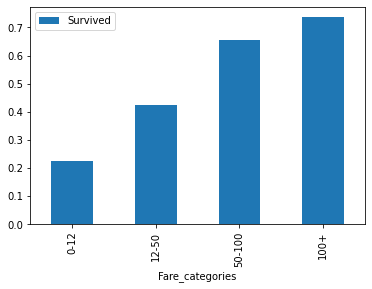

In [16]:
train.pivot_table(index='Fare_categories', values='Survived').plot.bar()
plt.show()

Let's examine the `SibSp` and `Parch` columns. These two columns are containing information about the family members each passenger had onboard. And we'll add these two columns up to create a columns containing total family on board.

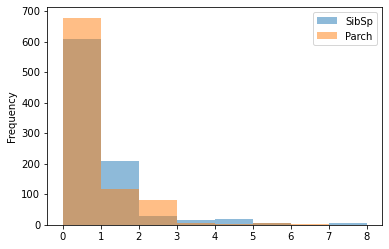

In [17]:
train[['SibSp', 'Parch']].plot.hist(alpha=0.5, bins=8)
plt.show()

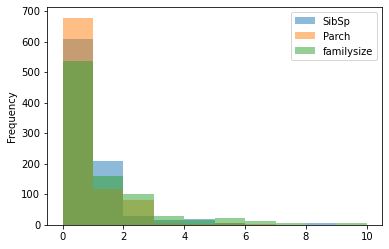

In [18]:
train['familysize'] = train[['SibSp', 'Parch']].sum(axis=1)
holdout['familysize'] = holdout[['SibSp', 'Parch']].sum(axis=1)

train[['SibSp', 'Parch', 'familysize']].plot.hist(alpha=0.5, bins=10)
plt.show()

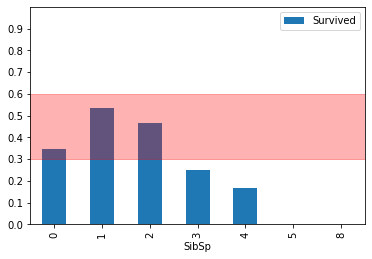

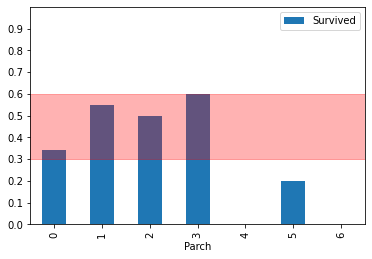

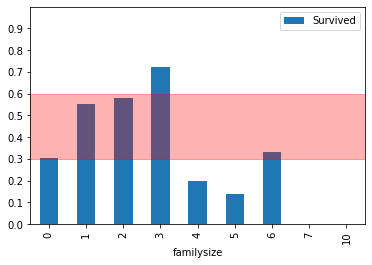

In [19]:
for col_name in ['SibSp', 'Parch', 'familysize']:
    train.pivot_table(index=col_name, values='Survived').plot.bar()
    plt.ylim([0,1])
    plt.axhspan(.3, .6,alpha=0.3, color='red')
    plt.yticks(np.arange(0,1,0.1))
    plt.show()



Looking at the survival rates of the the combined family members, typically, passengers with no family members has fewer survival rate.  
Based of this, we can create a new feature - was the passenger alone.

In [20]:
def process_isalone(df):
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

Lastly, let's take a look at `Cabin` columns

In [35]:
train['Cabin'].sample(10)

820    B69
29     NaN
784    NaN
647    A26
183     F4
14     NaN
367    NaN
34     NaN
885    NaN
103    NaN
Name: Cabin, dtype: object

We can see that the format of the cabin numbers is one letter followed by numbers. It seems like the letter is representative of the type of cabin, which could be useful data for us. We can extract the first character and create a new feature `Cabin_type`.


In [33]:
for df in (train, holdout):
    df['Cabin_type'] = df['Cabin'].str[0]
    df['Cabin_type'] = df['Cabin_type'].fillna('Unknown')

Before we build our model, we need to prepare these columns for machine learning. Most machine learning algorithms can't understand text labels, so we have to convert our values into numbers.

While `Pclass` column has some sort of ordered relationship, but the relationship between each class is not the same as the relationship between numbers 1, 2 and 3.

Therefore, we'll create a function to make dummy columns to fix these problems.

In [26]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

column_names =['Pclass', 'Sex', 'Embarked', 'Age_categories',
               'SibSp_scaled', 'Fare_categories','isalone', 'Cabin_type']

for column_name in column_names:
    train = create_dummies(train, column_name)
    holdout = create_dummies(holdout, column_name)

## Feature Selection

We will use scikit-learn's `feature_selection.RFECV class` to automate selecting the best-performing features using recursive feature elimination. And we choose Random Forest as the estimator.


In [29]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def select_features(df):
    
    # remove any non-numeric columns
    train_numeric=train.select_dtypes(include=[np.number])
    
    # drop columns containing null value
    train_numeric = train_numeric.dropna(axis=1)
    
    # prepare features and target
    all_X = train_numeric.drop(['Survived', 'PassengerId'], axis=1)
    all_y = train_numeric['Survived']
    
    rf = RandomForestClassifier(random_state=1)
    selector=RFECV(rf, cv=10)
    
    selector.fit(all_X, all_y)
    
    best_columns = all_X.columns[selector.support_].tolist()
    
    print(best_columns)
    
    return best_columns
    
    
cols=select_features(train)

['Pclass', 'Age', 'Parch', 'Fare', 'SibSp_scaled', 'Fare_scaled', 'Pclass_3', 'Sex_female', 'Sex_male']


## Algorithms Selection

we will use scikit-learn's `model_selection.GridSearchCV class` to find the best set of performing parameters, and add the best parameter set, score, and estimator to the dictionary.

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    
    models = [
        {'name': 'LogisticRegression',
         'estimator': LogisticRegression(),
         'hyperparameters': 
             {
             'solver': ['newton-cg', 'lbfgs', 'liblinear']
             }
        },
        {'name': 'KNeighborsClassifier',
         'estimator': KNeighborsClassifier(),
         'hyperparameters': 
             {
             'n_neighbors': range(1,20,2),
             "weights": ["distance", "uniform"],
             "algorithm": ["ball_tree", "kd_tree", "brute"],
             "p": [1,2]
             }
        },
        {'name': 'RandomForestClassifier',
         'estimator': RandomForestClassifier(),
         'hyperparameters': 
             {
             "n_estimators": [4, 6, 9],
             "criterion": ["entropy", "gini"],
             "max_depth": [2, 5, 10],
             "max_features": ["log2", "sqrt"],
             "min_samples_leaf": [1, 5, 8],
             "min_samples_split": [2, 3, 5]
             }
        }
    ]
    
    for model in models:
        print('Model: ', model['name'])
        selector = GridSearchCV(model['estimator'], 
                                model['hyperparameters'], 
                                cv=10)
        selector.fit(all_X, all_y)
        model['best_parameters'] = selector.best_params_
        model['best_score'] = selector.best_score_
        model['best_estimator'] = selector.best_estimator_
        
        print('Best parameters: ', selector.best_params_)
        print('Best score: ', selector.best_score_)
        
    return models

models = select_model(train, cols)

Model:  LogisticRegression


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

Best parameters:  {'solver': 'newton-cg'}
Best score:  0.7845068664169788
Model:  KNeighborsClassifier
Best parameters:  {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best score:  0.7688514357053682
Model:  RandomForestClassifier
Best parameters:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 4}
Best score:  0.8395380774032459


## Making a Submission to Kaggle

In [31]:
def save_submission_file(model, features, filename):
    prediction = model.predict(holdout[features])
    sub_dict = {
        'PassengerId': holdout['PassengerId'],
        'Survived': prediction
    }
    submission = pd.DataFrame(sub_dict)
    submission.to_csv('result_{}.csv'.format(filename), index=False)
    
save_submission_file(models[2]['best_estimator'], cols, 'rf')